# Correlation between the scores

In [2]:
# Required Libraries
import pandas as pd
import requests
import time

# Fetch Countries Based on Partner Data
def fetch_countries(api_key):
    headers = {"Ocp-Apim-Subscription-Key": api_key}
    url = "https://comtradeapi.un.org/data/v1/get/C/A/HS"
    params = {
        "reporterCode": "",  # UK as sample
        "period": 2022,
        "flowCode": "M",
        "cmdCode": "TOTAL",
        "freq": "A",
        "breakdownMode": "classic",
        "includeDesc": True
    }
    try:
        res = requests.get(url, params=params, headers=headers)
        if res.status_code == 200:
            data = res.json().get("data", [])
            partners = sorted(list({
                rec["partnerCode"]: rec["partnerDesc"]
                for rec in data if rec.get("partnerCode") and rec.get("partnerDesc")
            }.items()), key=lambda x: x[1])
            return [{"label": f"{name} ({code})", "value": str(code)} for code, name in partners]
    except Exception as e:
        print("❌ Exception while fetching countries:", e)
    return []

# === Helper Functions ===
def fetch_comtrade_data(params, api_key, retries=3):
    headers = {"Ocp-Apim-Subscription-Key": api_key}
    for attempt in range(retries):
        try:
            response = requests.get("https://comtradeapi.un.org/data/v1/get/C/A/HS", params=params, headers=headers)
            if response.status_code == 200:
                return response.json().get("data", [])
            elif response.status_code == 429:
                time.sleep(5 * (attempt + 1))
        except requests.exceptions.RequestException as e:
            print("Connection error:", e)
    return []

def is_valid_partner(partner):
    if not partner:
        return False
    partner = partner.lower()
    return not any(x in partner for x in ["world"])

import_dict = {}
export_dict = {}
export_count = {}
def get_trade_info(country_list, hs_code, year, api_key):
    params = {
        "reporterCode": "",
        "period": year,
        "flowCode": "",
        "cmdCode": hs_code,
        "freq": "A",
        "breakdownMode": "classic",
        "includeDesc": True
    }
    data = fetch_comtrade_data(params, api_key)
    for country in country_list:
        partner_values_import = {}
        partner_values_export = {}
        exporter_count = set()
        for rec in data:
            reporter = rec.get("reporterCode")
            reporter_name = rec.get("reporterDesc")
            partner = rec.get("partnerDesc")
            value = rec.get("primaryValue")
            if is_valid_partner(partner) and is_valid_partner(reporter_name) and value:
                if rec.get("flowCode") == "M":
                    exporter_count.add(partner)
                if reporter == country:
                    try:
                        val = float(value)
                        if val > 0:
                            if rec.get("flowCode") == "M":
                                partner_values_import[partner] = partner_values_import.get(partner, 0) + val
                            elif rec.get("flowCode") == "X":
                                partner_values_export[partner] = partner_values_export.get(partner, 0) + val
                    except ValueError:
                        continue
        import_dict[country] = partner_values_import
        export_dict[country] = partner_values_export
        export_count[country] = len(exporter_count) if exporter_count else 0
    
    return import_dict, export_dict, export_count


def calculate_scri(imports, exports, export_count):
   
    M = sum(imports.values())
    X = sum(exports.values())
    N = len(imports)
    HHI = sum((v / M) ** 2 for v in imports.values()) if M > 0 else 0.0
    DiversityScore = min(N / export_count, 1.0)
    IDI = max(min((M - X) / M, 1.0), 0.0) if M > 0 else 0.0
    SCRI = round((HHI +  (1-DiversityScore) + IDI)/3, 4)
    return {
        "Total Imports": M,
        "Total Exports": X,
        "HHI": round(HHI, 4),
        "Diversity Score": round(DiversityScore, 4),
        "IDI": round(IDI, 4),
        "SCRI": SCRI,
        "Import Partners": N
    }

In [3]:
import os
api_key = os.getenv("API_KEY")
# Get the list of countries
countries = fetch_countries(api_key)

In [4]:
# Get the scores for all the countries
scri_dict = {}
hs_codes = [28, 90, 30, 27, 85]
hs_values = ["Chemicals", "Medical Instruments", "Pharmaceuticals", "Minerals", "Electrical equipment"]
year = 2022
country_codes = [int(country["value"]) for country in countries]
for hs_code in hs_codes:
    import_data, export_data, export_count = get_trade_info(country_codes, hs_code, year, api_key)
    # Append the score only if import and export data exist
    for code in country_codes:
        key = (hs_code,code)
        if import_data[code] and export_data[code]:
            scri_result = calculate_scri(import_data[code], export_data[code], export_count[code])
            scri_dict[key] = scri_result

In [5]:
# Calculate the correlation matrix
scores_df=[]
correlation_matrix=[]
for code in hs_codes:
    filtered_scores = [
        {
            'HHI': scores['HHI'],
            'Diversity_score': scores['Diversity Score'],
            'IDI': scores['IDI']
        }
        for scores in [scores for (hs, _), scores in scri_dict.items() if hs == code]

    ]
    scores_df.append(pd.DataFrame(filtered_scores))
    correlation_matrix.append(scores_df[-1].corr())


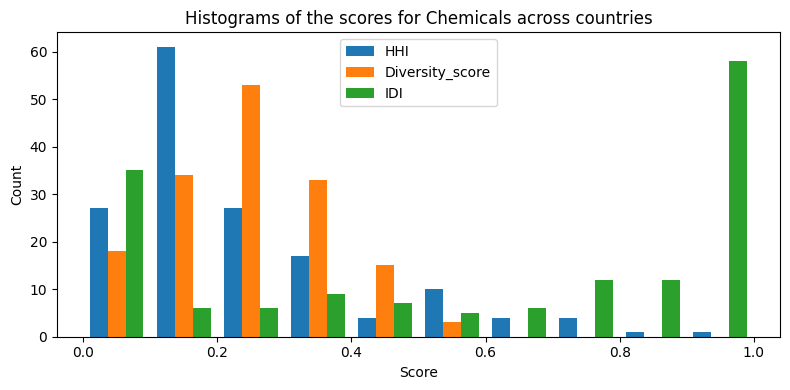

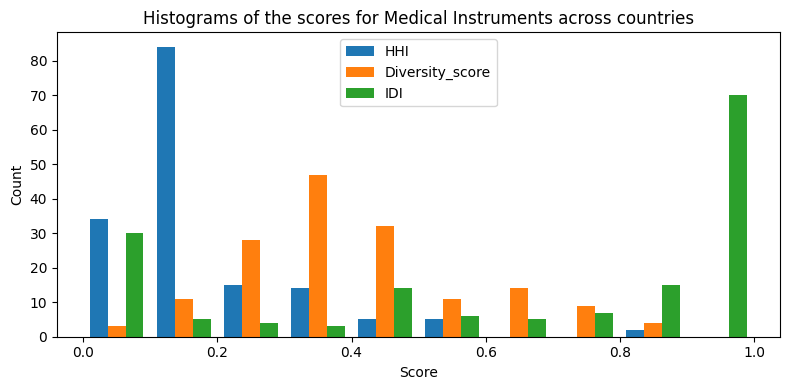

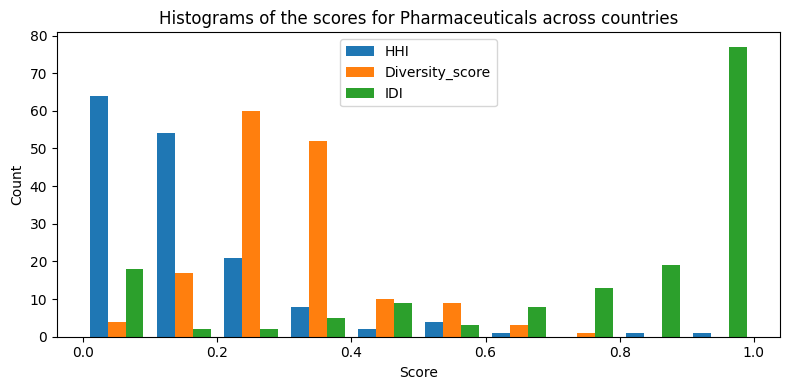

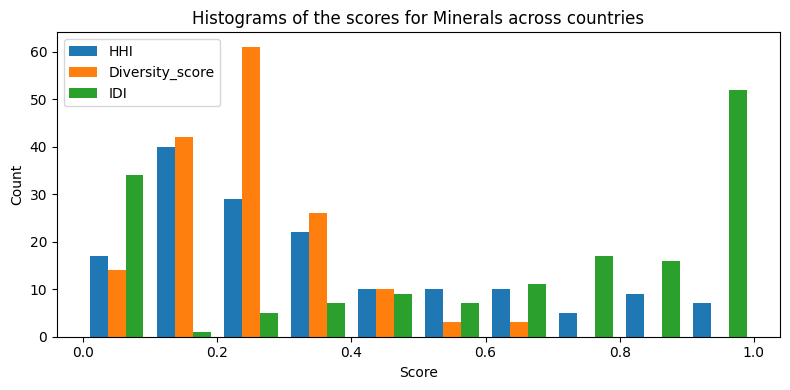

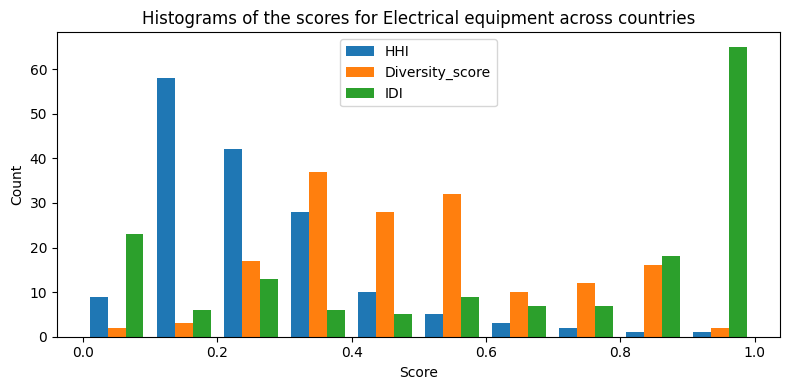

In [6]:
import matplotlib.pyplot as plt
for i in range(len(hs_codes)):
    plt.figure(figsize=(8,4))
    plt.hist(scores_df[i], label=scores_df[i].columns)
    plt.legend()
    plt.title(f"Histograms of the scores for {hs_values[i]} across countries")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

Info for Chemicals
25th Percentile of SCRI scores: 0.3550
75th Percentile of SCRI scores: 0.6682


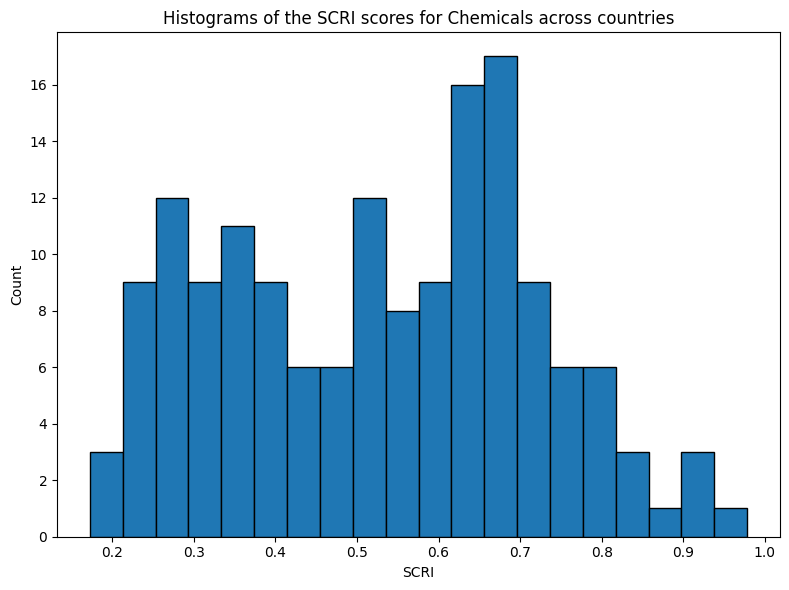

Info for Medical Instruments
25th Percentile of SCRI scores: 0.3144
75th Percentile of SCRI scores: 0.6022


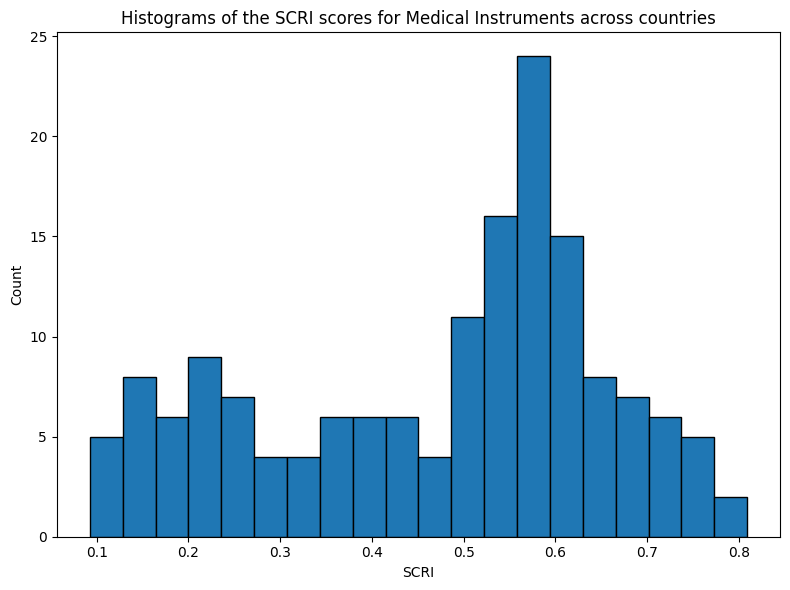

Info for Pharmaceuticals
25th Percentile of SCRI scores: 0.4518
75th Percentile of SCRI scores: 0.6284


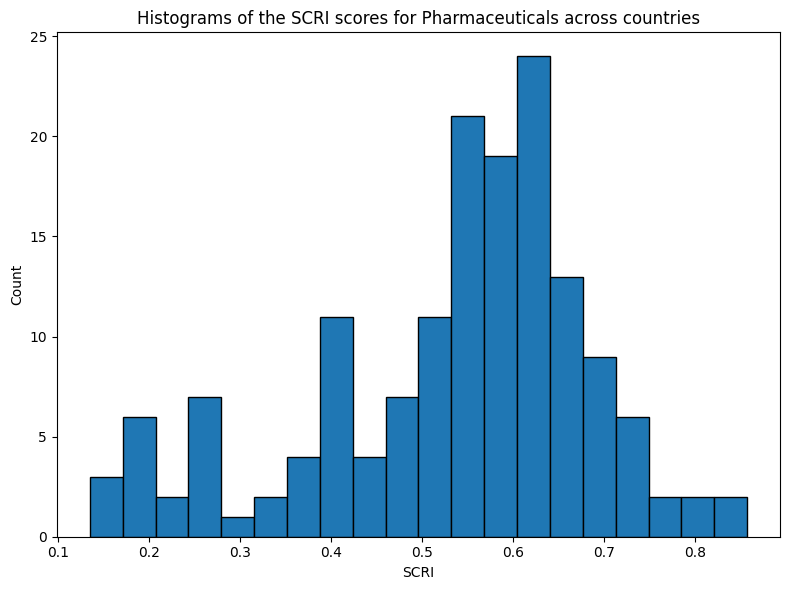

Info for Minerals
25th Percentile of SCRI scores: 0.4351
75th Percentile of SCRI scores: 0.7155


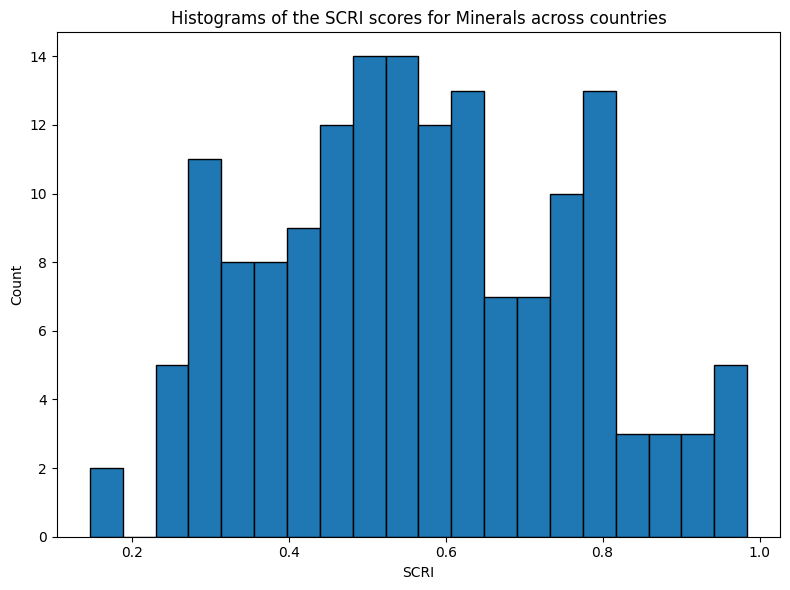

Info for Electrical equipment
25th Percentile of SCRI scores: 0.2886
75th Percentile of SCRI scores: 0.6161


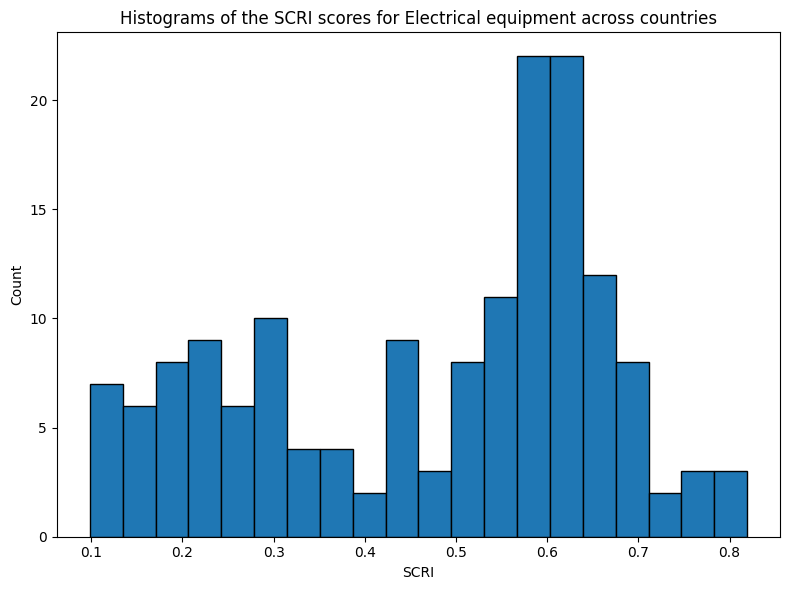

Average 20th percentile of SCRI scores: 0.368975
Average 80th percentile of SCRI scores: 0.646085


In [7]:
import numpy as np
percentile_25_list = []
percentile_75_list = []
for i,code in enumerate(hs_codes):
    print(f"Info for {hs_values[i]}")
    scri = [scores["SCRI"] for (hs, _), scores in scri_dict.items() if hs == code]
    percentile_25 = np.percentile(scri, 25)
    percentile_25_list.append(percentile_25)
    print(f"25th Percentile of SCRI scores: {percentile_25:.4f}")
    percentile_75 = np.percentile(scri, 75)
    percentile_75_list.append(percentile_75)
    print(f"75th Percentile of SCRI scores: {percentile_75:.4f}")

    plt.figure(figsize=(8,6))
    plt.hist(scri, bins=20, edgecolor='black')
    plt.title(f"Histograms of the SCRI scores for {hs_values[i]} across countries")
    plt.xlabel("SCRI")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
print(f"Average 20th percentile of SCRI scores: {sum(percentile_25_list)/len(percentile_25_list)}")
print(f"Average 80th percentile of SCRI scores: {sum(percentile_75_list)/len(percentile_75_list)}")

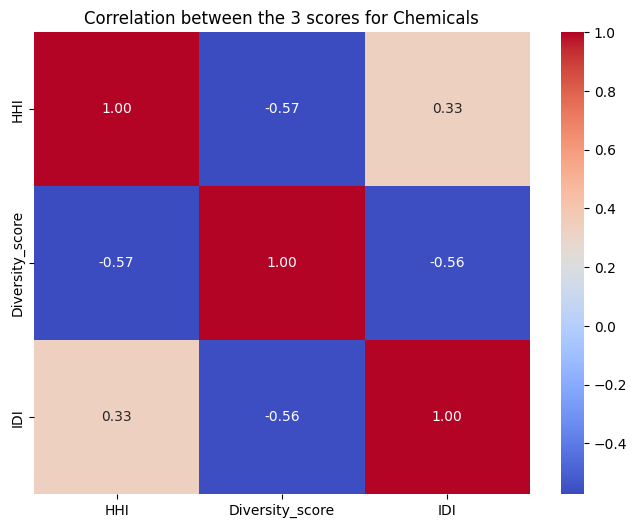

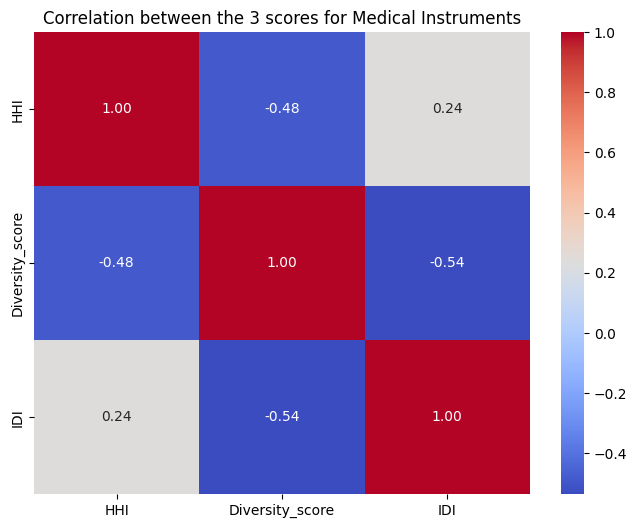

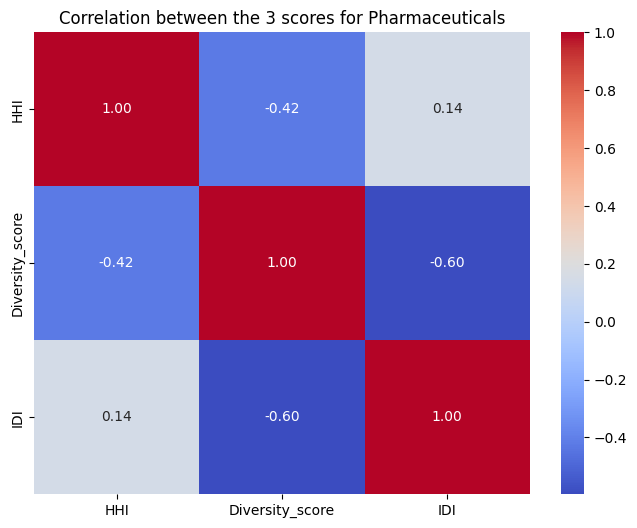

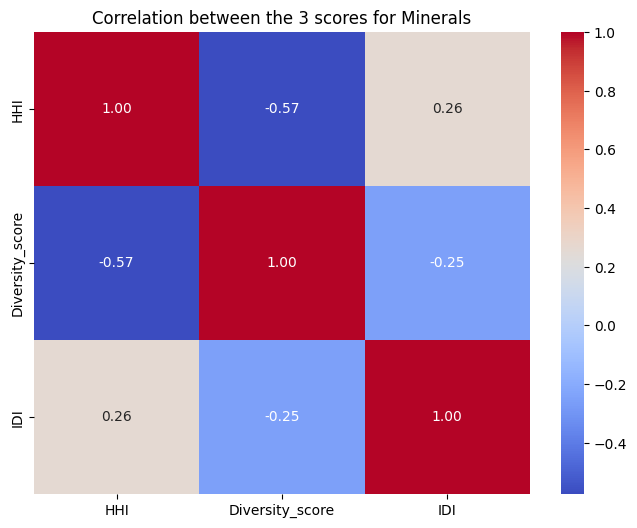

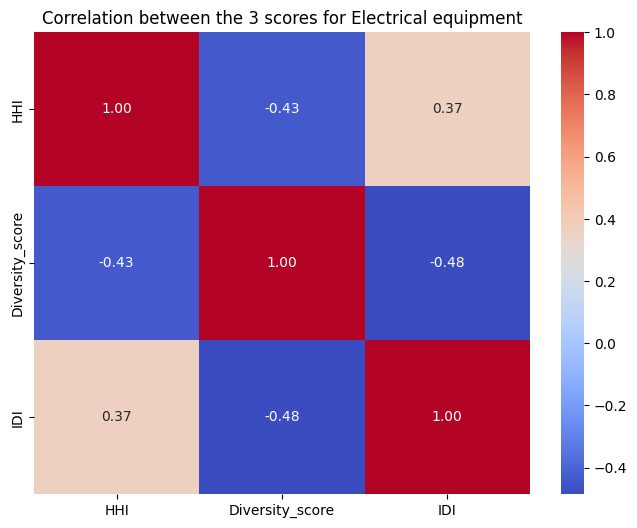

In [9]:
# Plot the correlation
import seaborn as sns

for i,matrix in enumerate(correlation_matrix):
    plt.figure(figsize = (8,6))
    sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation between the 3 scores for {hs_values[i]}')
    plt.show()

To ensure the three chosen metrics - Herfindahl-Hirschman Index (HHI), Supplier Diversity Score (S), and Import Dependency Index (IDI) add unique value to the final risk calculation, a correlation analysis was carried out. The scores for 143 countries for which data was available was calculated and compared for the trade of semiconductors in the year 2022.

The goal was to assess whether any of the metrics were redundant—that is, if two scores were highly correlated, they might be capturing the same aspect of supply chain risk. The highest observed correlation was –0.60 between IDI and the diversity score, suggesting that in some cases, countries that rely heavily on imports may also tend to have fewer supplier sources. However, this correlation was moderate at best and not strong enough to justify removing either variable. The remaining correlations were even lower, supporting the decision to retain all three scores.

After analyzing the SCRI score distributions, we found that using a multiplicative method resulted in scores that were consistently low, even for commodities known to have higher vulnerability. To address this, we updated our calculation by taking the average of the three scores — HHI, (1 – Diversity), and IDI — instead of multiplying them. This adjustment brought the SCRI values onto a more meaningful scale. By averaging the 20th and 80th percentiles across different commodities, we observed that the 25th percentile typically falls around 0.35 and the 75th percentile around 0.65. This method ensures that our low, medium, and high risk classifications remain consistent with the overall distribution of supply chain risk across sectors.